In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
## Importing data

milk = pd.read_csv("/UdemyCourses/Tensorflow-Bootcamp-master/04-Recurrent-Neural-Networks/monthly-milk-production.csv" 
                   , index_col = "Month")

In [3]:
milk.head()


,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [4]:
## Make the index a time series index

milk.index = pd.to_datetime(milk.index)

In [5]:
milk.index

DatetimeIndex(['1962-01-01 01:00:00', '1962-02-01 01:00:00',
               '1962-03-01 01:00:00', '1962-04-01 01:00:00',
               '1962-05-01 01:00:00', '1962-06-01 01:00:00',
               '1962-07-01 01:00:00', '1962-08-01 01:00:00',
               '1962-09-01 01:00:00', '1962-10-01 01:00:00',
               ...
               '1975-03-01 01:00:00', '1975-04-01 01:00:00',
               '1975-05-01 01:00:00', '1975-06-01 01:00:00',
               '1975-07-01 01:00:00', '1975-08-01 01:00:00',
               '1975-09-01 01:00:00', '1975-10-01 01:00:00',
               '1975-11-01 01:00:00', '1975-12-01 01:00:00'],
              dtype='datetime64[ns]', name='Month', length=168, freq=None)

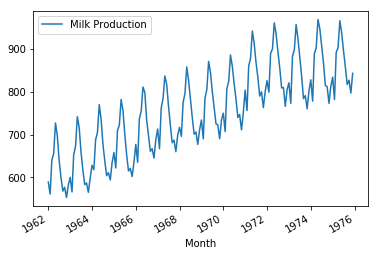

In [6]:
milk.plot()

### Train Test Split
#### # Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) 

#### # Create a test train split using indexing (hint: use .head() or tail() or .iloc[]). We don't want a random train test split, we want to specify that the test set is the last 3 months of data is the test set, with everything before it is the training. 

In [7]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [8]:
train_set = milk.head(156)

test_set = milk.tail(12)

### Scale the Data

####  Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_set)

test_scaled = scaler.fit_transform(test_set)

### Batch Function

####  We'll need a function that can feed batches of the training data. We'll need to do several things that are listed out as steps in the comments of the function. Remember to reference the previous batch method from the lecture for hints. Try to fill out the function template below, this is a pretty hard step, so feel free to reference the solutions! 

In [10]:
def next_batch(training_data , batch_size , steps):
    
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    rand_start = np.random.randint(0 , len(training_data) - steps)
    
    #STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps. Then reshape this data to be (1,steps)
    y_batch = np.array(training_data[rand_start : rand_start + steps + 1]).reshape(1 , steps + 1)
    
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN. Depending on your indexing it
    # will be either .reshape(-1,steps-1,1) or .reshape(-1,steps,1)
    return y_batch[: , :-1].reshape(-1 , steps , 1) , y_batch[: , 1:].reshape(-1 , steps , 1)
    

## Setting up the RNN Model

### The Constants
#### ** Define the constants in a single cell. You'll need the following (in parenthesis are the values I used in my solution, but you can play with some of these): **
#### Number of Inputs (1)
#### Number of Time Steps (12)
#### Number of Neurons per Layer (100)
#### Number of Outputs (1)
#### Learning Rate (0.003)
#### Number of Iterations for Training (4000)
#### Batch Size (1)

In [11]:
num_inputs = 1

num_time_steps = 12

num_neurons = 100

num_outputs = 1

learning_rate = 0.001

num_train_iterations = 6000

batch_size = 1

#### Create Placeholders for X and y. (You can change the variable names if you want). The shape for these placeholders should be [None,num_time_steps-1,num_inputs] and [None, num_time_steps-1, num_outputs] The reason we use num_time_steps-1 is because each of these will be one step shorter than the original time steps size, because we are training the RNN network to predict one point into the future based on the input sequence.

In [12]:
X = tf.placeholder(tf.float32 , shape = (None , num_time_steps , num_inputs ))
y = tf.placeholder(tf.float32 , shape = (None , num_time_steps , num_outputs))

#### Now create the RNN Layer, you have complete freedom over this, use tf.contrib.rnn and choose anything you want, OutputProjectionWrappers, BasicRNNCells, BasicLSTMCells, MultiRNNCell, GRUCell etc... Keep in mind not every combination will work well! (If in doubt, the solutions used an Outputprojection Wrapper around a basic LSTM cell with relu activation.

In [13]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(num_units = num_neurons , activation = tf.nn.relu) , output_size = num_outputs)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.


In [14]:
## Now pass in the cell variables into tf.nn.dynamic_rnn, along with your first placeholder(X)

outputs , states = tf.nn.dynamic_rnn(cell , X , dtype = tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [15]:
## Loss Function and Optimizer

loss = tf.reduce_mean(tf.square(outputs - y))

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = optimizer.minimize(loss)

In [16]:
## Initialize the global variables

init = tf.global_variables_initializer()

## Create an instance of tf.train.Saver()
saver = tf.train.Saver()

#### Run a tf.Session that trains on the batches created by your next_batch function. Also add an a loss evaluation for every 100 training iterations. Remember to save your model after you are done training.

In [17]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch , y_batch = next_batch(train_scaled , batch_size , num_time_steps)
        
        sess.run(train , feed_dict = {X: X_batch , y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict = {X: X_batch , y: y_batch})
            print(iteration , "\tMSE" , mse)
            
    ## Save Model for Later
    saver.save(sess , "./time_series_model_milk_production")
        

0 	MSE 0.5148997
100 	MSE 0.054560423
200 	MSE 0.02787204
300 	MSE 0.008948971
400 	MSE 0.009940728
500 	MSE 0.0072723646
600 	MSE 0.009435077
700 	MSE 0.007038102
800 	MSE 0.009906837
900 	MSE 0.008188431
1000 	MSE 0.006732268
1100 	MSE 0.010899982
1200 	MSE 0.011119966
1300 	MSE 0.009577858
1400 	MSE 0.0040432154
1500 	MSE 0.0046046907
1600 	MSE 0.008416233
1700 	MSE 0.006600887
1800 	MSE 0.009542453
1900 	MSE 0.0039273025
2000 	MSE 0.0076582176
2100 	MSE 0.0061656483
2200 	MSE 0.006148008
2300 	MSE 0.004777893
2400 	MSE 0.011655774
2500 	MSE 0.006413082
2600 	MSE 0.0053915507
2700 	MSE 0.0062906505
2800 	MSE 0.006902944
2900 	MSE 0.006706532
3000 	MSE 0.0026751894
3100 	MSE 0.0021979818
3200 	MSE 0.0037469848
3300 	MSE 0.003246439
3400 	MSE 0.0073977206
3500 	MSE 0.0069725513
3600 	MSE 0.00446281
3700 	MSE 0.0068528093
3800 	MSE 0.004393317
3900 	MSE 0.0042126565
4000 	MSE 0.011544298
4100 	MSE 0.005377388
4200 	MSE 0.0046680034
4300 	MSE 0.005313149
4400 	MSE 0.00071918545
4500 	MS

## Predicting Future (Test Data)

In [18]:
test_set

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0


#### Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our generated 12 months to our actual true historical values from the test set! 

## Generative Session
### NOTE: Recall that our model is really only trained to predict 1 time step ahead, asking it to generate 12 steps is a big ask, and technically not what it was trained to do! Think of this more as generating new values based off some previous pattern, rather than trying to directly predict the future. You would need to go back to the original model and train the model to predict 12 time steps ahead to really get a higher accuracy on the test data. (Which has its limits due to the smaller size of our data set)

In [19]:
with tf.Session() as sess:
    
    saver.restore(sess , "./time_series_model_milk_production")
    
    train_seed = list(train_scaled[-12:])
    
    for iteration in range(12):
        
        X_batch = np.array(train_seed[-num_time_steps :]).reshape(1 , num_time_steps , 1)
        
        y_pred = sess.run(outputs , feed_dict = {X: X_batch})
        
        train_seed.append(y_pred[0 , -1 , 0])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./time_series_model_milk_production


In [20]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.6881942,
 0.60337526,
 0.83977187,
 0.8970257,
 1.0643846,
 1.0137278,
 0.8950718,
 0.801955,
 0.6705008,
 0.66947705,
 0.5660715,
 0.66707695]

### Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.

In [21]:
results = scaler.inverse_transform(np.array(train_seed[12 :]).reshape(12 , 1))


In [22]:
## Create a new column on the test_set called "Generated" and set it equal to the generated results. 
## You may get a warning about this, feel free to ignore it.

test_set["Generated"] = results

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,908.627747
1975-02-01 01:00:00,782.0,893.021057
1975-03-01 01:00:00,892.0,936.518005
1975-04-01 01:00:00,903.0,947.052734
1975-05-01 01:00:00,966.0,977.846741
1975-06-01 01:00:00,937.0,968.525879
1975-07-01 01:00:00,896.0,946.693237
1975-08-01 01:00:00,858.0,929.559753
1975-09-01 01:00:00,817.0,905.372131


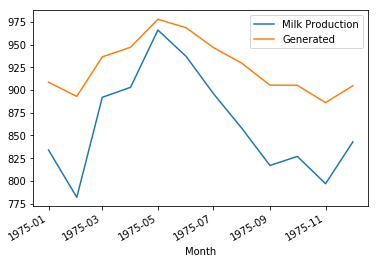

In [24]:
test_set.plot()